# Phase Tools

> Some routines for phase extraction from time series

In [ ]:
#| default_exp phasetools

In [ ]:
#| export 

import circadian 


In [ ]:
#| hide 
from fastcore.test import *

In [ ]:
#| export 

import numpy as np 
import matplotlib.pyplot as plt
import scipy as sp 
from typing import List 
import numpy.linalg 

# Cosinor Analysis

The simplest and one of the most popular techniques is so-called cosinor analysis, which is a very fancy term for doing a linear regression on cosine transformed data. 

$$ y = A \cos(x + \beta) $$ 

or in the form that I prefer:

$$q(t,\phi) = a_1 \sin(\omega t) + a_2 \cos(\omega t) $$

In cosinor analysis the $\omega$ term (the frequency) is taken as a known quantity and the $a_{1,2}$ terms are fit to minimize the least square error. 

Then the phase $\phi$ is given by $\arg(a_2 + i a_1)$

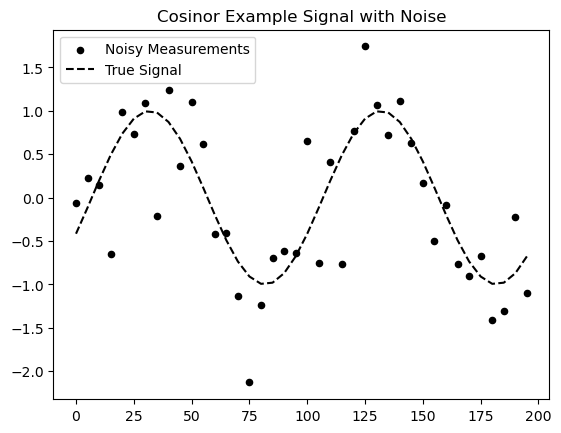

In [ ]:
#| label: cosinor-example-data
#| fig-cap: "Example Cosinor Data"

def f_signal_cosinor(t: np.array, phi: float, tau: float = 100.0) -> np.array:
    return np.cos(2 * np.pi/tau * t - phi)

phi_true = 2.0
x_sample = np.arange(0, 200, 5)
y_sample = f_signal_cosinor(x_sample, phi_true) 
y_sample_noisy = y_sample + np.random.normal(0, 0.5, x_sample.shape)

plt.scatter(x_sample,y_sample_noisy, color='k', s=20, label='Noisy Measurements')
plt.plot(x_sample, y_sample, ls = '--', color = 'k', label = 'True Signal');
plt.legend()
plt.title('Cosinor Example Signal with Noise');

It is easy enough to use built in regression functions to find $a_{1,2}$ but we can easily solve this ourselves. First, lets define the terms $y$ is the signal, $t$ is the sampling times the same length as $y$. The matrix $S$ is formed by taking the sin/cos of the time vectors and placing them in the columns $S = [sin(\omega t); cos(\omega t)]$. Thus, we can write our system as:

$$ S a = y $$

where $a = [a_1, a_2]$ are the two coefficients we want to solve for. This regression is especially easy to compute in this case because 
the matrix $S$ has the property that the columns are orthogonal (S is a orthogonal matrix). This means that $S^T S = I$, and we can solve the system with one matrix transpose multiplication. 

\begin{align}
Sa = y \\
S^T S a = S^T y, S^T S = I \\
a = S^T y 
\end{align}

Since $S^T$ only has two columns we can write the matrix-vector product out for each component: 

\begin{align}
a_1 = \frac{ \sin(\omega t) \cdot y}  { || \sin(\omega t) ||^2 } \\
a_2 = \frac { \cos(\omega t) \cdot y } { || \cos(\omega t) ||^2 }
\end{align}
Here is a quick implementation in python. 

In [ ]:
#| export 

def cosinor(t: np.array, # time vector
                  y: np.array, # signal vector
                  tau: float # period of cosinor analysis 
                  ) -> float: # phase estimate
    
    omega = 2*np.pi/tau 
    sin_transform = np.sin(omega*t)
    cos_transform = np.cos(omega*t)
    a1 = np.dot(y, sin_transform) / np.dot(sin_transform, sin_transform)
    a2 = np.dot(y, cos_transform) / np.dot(cos_transform, cos_transform)
    return np.array([a1, a2])


In [ ]:
#| export 


def cosinor_phase(a: np.array) -> float: 
    z = a[1]+ complex(0,1)*a[0]
    return np.angle(z)

Recovered Cosinor Parameters 0.9207 sin(omega t) + -0.3776 cos(omega t)
Phase Estimate: 1.9600 versus the true phase: 2.0000


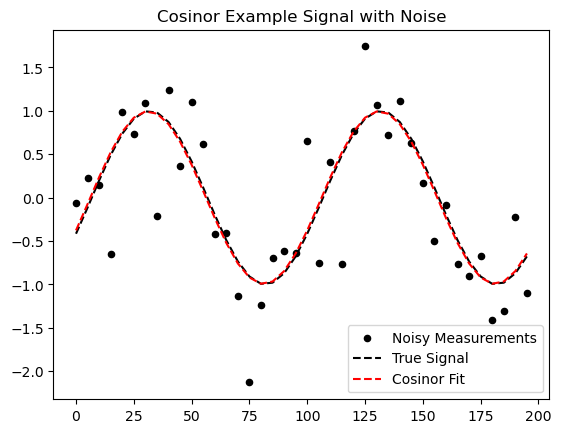

In [ ]:
a_coeffs = cosinor(x_sample, y_sample_noisy, 100.0)
print(f"Recovered Cosinor Parameters {a_coeffs[0]:.4f} sin(omega t) + {a_coeffs[1]:.4f} cos(omega t)")
print(f"Phase Estimate: {cosinor_phase(a_coeffs):.4f} versus the true phase: {phi_true:.4f}")


plt.scatter(x_sample,y_sample_noisy, color='k', s=20, label='Noisy Measurements')
plt.plot(x_sample, y_sample, ls = '--', color = 'k', label = 'True Signal')
plt.plot(x_sample, a_coeffs[0]*np.sin(2*np.pi/100.0 *x_sample) + a_coeffs[1]*np.cos(2*np.pi/100.0 *x_sample), ls = '--', color = 'r', label = 'Cosinor Fit');
plt.legend()
plt.title('Cosinor Example Signal with Noise');

## GOALS: Cosinor with gaps 

One of the main challenges with the cosinor method is that it assumes that the data is continuous. This is not always the case. For example, if you are measuring a signal at a fixed time interval, but the signal is not present at all times, then you will have gaps in your data.

The GOALs algorithm (citation) is a modification of the cosinor method that allows for gaps in the data. 

In [ ]:
#| export 

def cosinor_goals(t, y, tau: float):
    omega = 2*np.pi/tau 
    A = np.stack((np.ones(len(t)), np.sin(omega*t), np.cos(omega*t)), axis=1)
    
    Q,R = np.linalg.qr(A)
    x1 = Q[:,1]
    x2 = Q[:,2] 
    
    z = complex(0,1)*np.dot(x1,y) /np.dot(x1,np.sin(omega*t)) + np.dot(x2,y)/np.dot(x2,np.cos(omega*t))
    return np.array([z.imag, z.real])
    

Recovered GOALS Cosinor Parameters 0.3053 sin(omega t) + -0.7676 cos(omega t)
GOALS Phase Estimate: 2.7630 versus the true phase: 2.0000
Recovered Cosinor Parameters 0.5447 sin(omega t) + -0.5027 cos(omega t)
Regular Cosinor Phase Estimate: 2.3162 versus the true phase: 2.0000


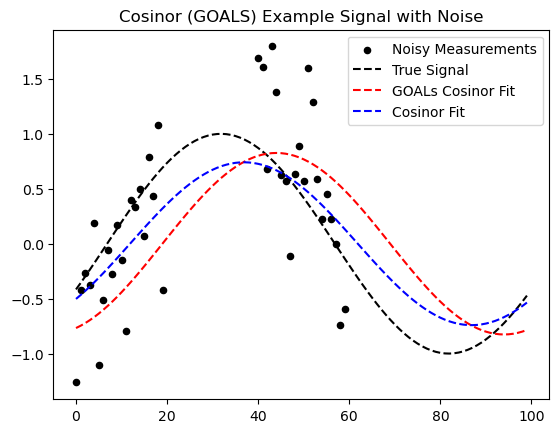

In [ ]:
phi_true = 2.0
x_sample = np.hstack((np.arange(0, 20, 1), np.arange(40, 60, 1)))
y_sample = f_signal_cosinor(x_sample, phi_true) 
y_sample_noisy = y_sample + np.random.normal(0, 0.5, x_sample.shape)

a_coeffs = cosinor_goals(x_sample, y_sample_noisy, 100.0)
print(f"Recovered GOALS Cosinor Parameters {a_coeffs[0]:.4f} sin(omega t) + {a_coeffs[1]:.4f} cos(omega t)")
print(f"GOALS Phase Estimate: {cosinor_phase(a_coeffs):.4f} versus the true phase: {phi_true:.4f}")


a_coeffs_plain = cosinor(x_sample, y_sample_noisy, 100.0)
print(f"Recovered Cosinor Parameters {a_coeffs_plain[0]:.4f} sin(omega t) + {a_coeffs_plain[1]:.4f} cos(omega t)")
print(f"Regular Cosinor Phase Estimate: {cosinor_phase(a_coeffs_plain):.4f} versus the true phase: {phi_true:.4f}")

x_fill = np.arange(0, 100, 1)
y_fill = f_signal_cosinor(x_fill, phi_true)
plt.scatter(x_sample,y_sample_noisy, color='k', s=20, label='Noisy Measurements')
plt.plot(x_fill, y_fill, ls = '--', color = 'k', label = 'True Signal')
plt.plot(x_fill, a_coeffs[0]*np.sin(2*np.pi/100.0 *x_fill) + a_coeffs[1]*np.cos(2*np.pi/100.0 *x_fill), ls = '--', color = 'r', label = 'GOALs Cosinor Fit');
plt.plot(x_fill, a_coeffs_plain[0]*np.sin(2*np.pi/100.0 *x_fill) + a_coeffs_plain[1]*np.cos(2*np.pi/100.0 *x_fill), ls = '--', color = 'b', label = 'Cosinor Fit');
plt.legend()
plt.title('Cosinor (GOALS) Example Signal with Noise');

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()